# **Kidney Dieses Classification in 4 classes using 3 different models (VGG, MOBILENET, RESNET)**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import (Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D)


In [22]:
batch_size = 16
img_height = 224
img_width = 224

In [23]:
data_dir='/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

train=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.1,
                                                subset='training',seed=123)
val=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(img_height,img_width),
                                                validation_split=0.2,
                                                subset='validation',seed=123)

Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [24]:
label_to_class_name = dict(zip(range(len(train.class_names)), train.class_names))
label_to_class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [25]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


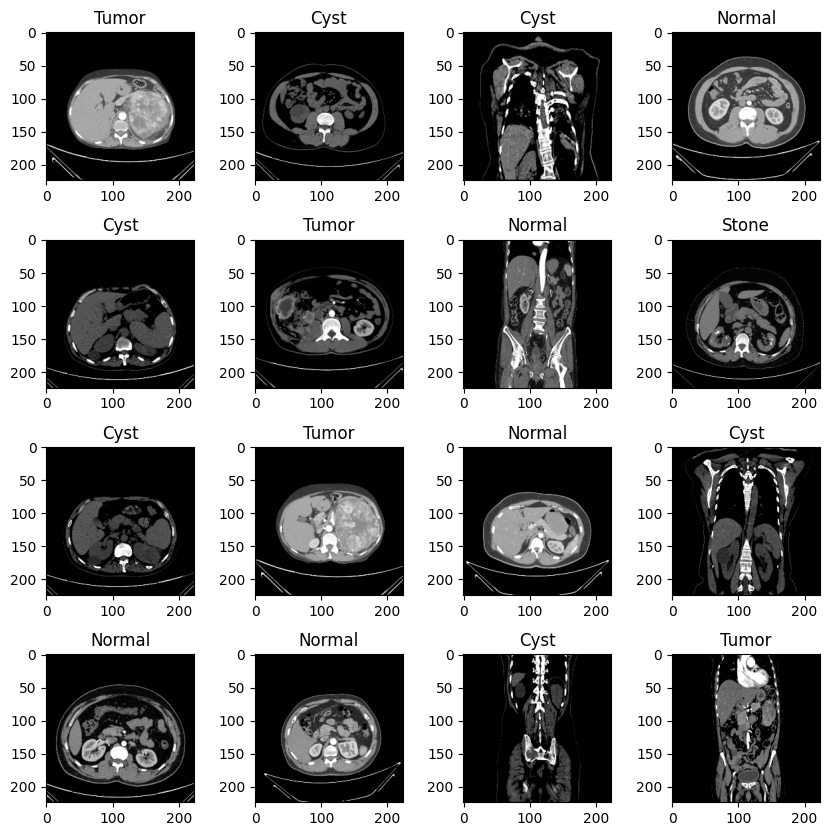

In [26]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):  
    for j in range(4):  
        index = i * 4 + j  
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(label_to_class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [27]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

**VGG16**

In [29]:
VGG_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False, input_shape=(224,224,3), pooling='max',classes=4, weights='imagenet')


VGG_model.add(pretrained_model)
VGG_model.add(Flatten())
VGG_model.add(Dense(512, activation='relu'))
VGG_model.add(BatchNormalization())  # Batch Normalization layer
VGG_model.add(Dropout(0.5))

VGG_model.add(Dense(4, activation='softmax'))
pretrained_model.trainable=False

In [31]:
VGG_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [32]:
VGG_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                      

In [33]:
epochs=10
history = VGG_model.fit(
    train,
    validation_data=val,
    epochs=epochs
)

Epoch 1/10
351/351 [==============================] - 49s 122ms/step - loss: 0.4087 - accuracy: 0.8543 - val_loss: 0.5220 - val_accuracy: 0.7658
Epoch 2/10
351/351 [==============================] - 28s 80ms/step - loss: 0.1323 - accuracy: 0.9564 - val_loss: 0.4810 - val_accuracy: 0.8051
Epoch 3/10
351/351 [==============================] - 28s 80ms/step - loss: 0.0910 - accuracy: 0.9688 - val_loss: 1.3101 - val_accuracy: 0.5597
Epoch 4/10
351/351 [==============================] - 28s 80ms/step - loss: 0.0792 - accuracy: 0.9718 - val_loss: 1.2452 - val_accuracy: 0.5838
Epoch 5/10
351/351 [==============================] - 28s 80ms/step - loss: 0.0620 - accuracy: 0.9795 - val_loss: 0.2436 - val_accuracy: 0.8980
Epoch 6/10
351/351 [==============================] - 28s 80ms/step - loss: 0.0603 - accuracy: 0.9785 - val_loss: 4.1966 - val_accuracy: 0.3078
Epoch 7/10
351/351 [==============================] - 28s 80ms/step - loss: 0.0562 - accuracy: 0.9812 - val_loss: 2.4325 - val_accuracy

In [35]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('VGG_training.csv', index=False)

In [36]:
VGG_model.save('VGG_model.h5')

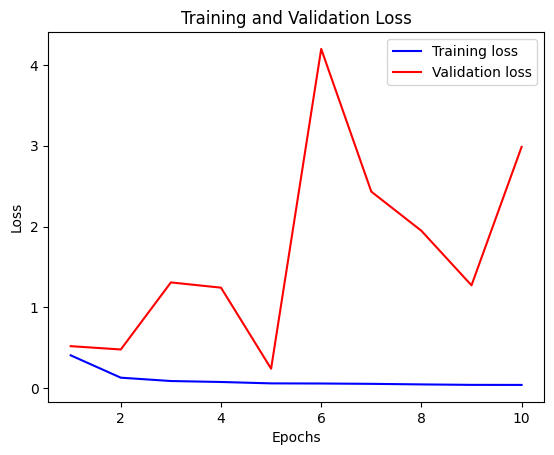

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

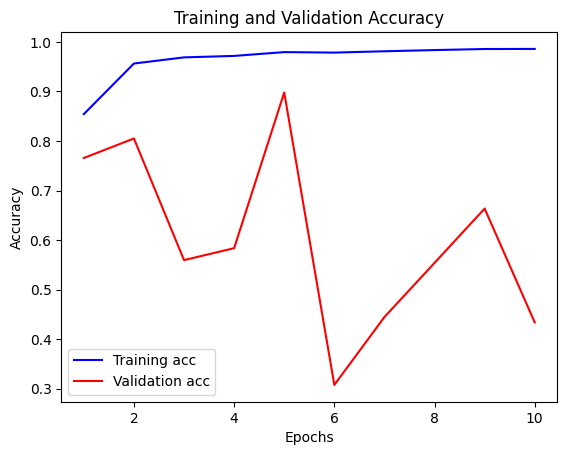

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf


In [41]:
import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf
predictions = VGG_model.predict(val)

true_labels = np.concatenate([y for x, y in val], axis=0)

cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

with open('confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)


78/78 [==============================] - 5s 63ms/step


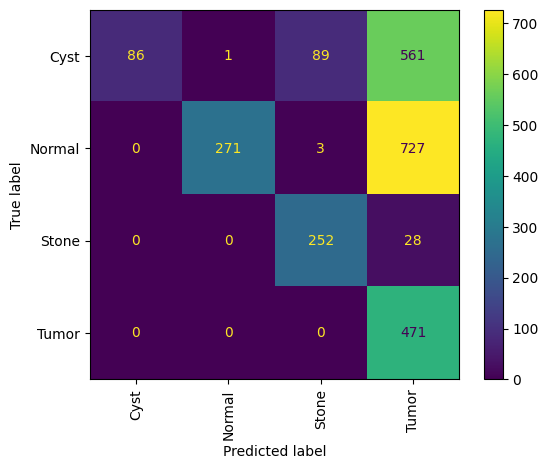

In [43]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

with open('confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']  

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

plt.show()


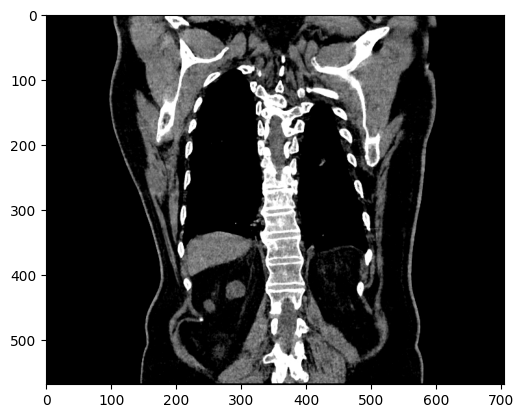

1/1 [==============================] - 0s 432ms/step


'Tumor'

In [46]:
img = cv2.imread('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = VGG_model.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

**MOBILENET**

In [47]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
input_shape = (224, 224, 3)
MobileNetV2_model = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

for _ in range(8):
    MobileNetV2_model.layers.pop()
for layer in MobileNetV2_model.layers:
    layer.trainable = True

x = GlobalAveragePooling2D()(MobileNetV2_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
output = Dense(4, activation='softmax')(x)

mobile_net = Model(inputs=MobileNetV2_model.input, outputs=output)

9406464/9406464 [==============================] - 1s 0us/step


In [49]:
mobile_net.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# mobile_net.summary()


In [50]:
epochs=15
history = mobile_net.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15
351/351 [==============================] - 64s 93ms/step - loss: 0.3019 - accuracy: 0.9351 - val_loss: 7.1010 - val_accuracy: 0.3238
Epoch 2/15
351/351 [==============================] - 31s 88ms/step - loss: 0.1427 - accuracy: 0.9796 - val_loss: 7.9844 - val_accuracy: 0.5689
Epoch 3/15
351/351 [==============================] - 31s 88ms/step - loss: 0.1433 - accuracy: 0.9762 - val_loss: 12.8261 - val_accuracy: 0.4082
Epoch 4/15
351/351 [==============================] - 31s 87ms/step - loss: 0.1025 - accuracy: 0.9833 - val_loss: 3.1516 - val_accuracy: 0.5729
Epoch 5/15
351/351 [==============================] - 31s 88ms/step - loss: 0.0691 - accuracy: 0.9909 - val_loss: 1.2608 - val_accuracy: 0.8015
Epoch 6/15
351/351 [==============================] - 30s 87ms/step - loss: 0.0463 - accuracy: 0.9942 - val_loss: 0.9251 - val_accuracy: 0.8819
Epoch 7/15
351/351 [==============================] - 30s 87ms/step - loss: 0.0329 - accuracy: 0.9958 - val_loss: 2.1829 - val_accuracy

In [52]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('MobileNet_training.csv', index=False)
mobile_net.save('MobileNet_model.h5')

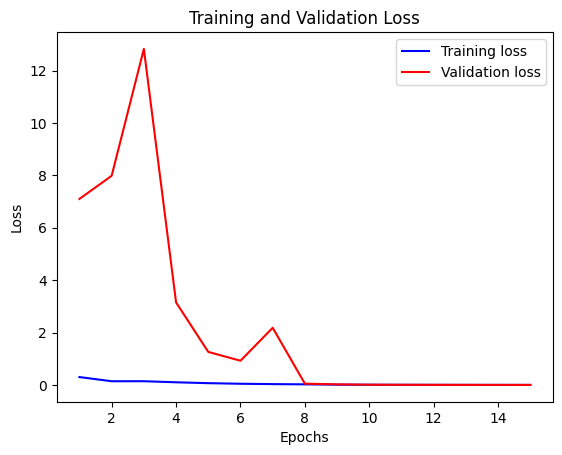

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

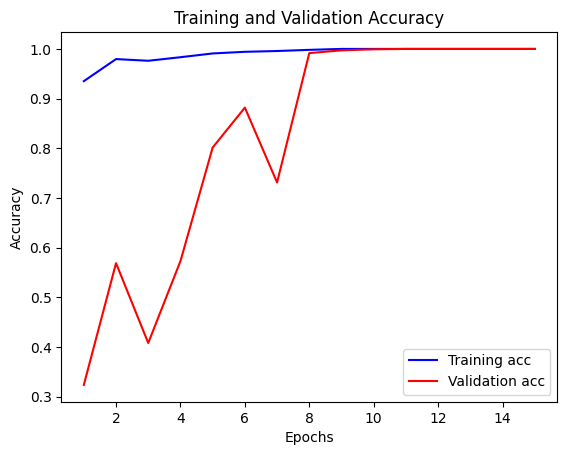

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [55]:
import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf


predictions = mobile_net.predict(val)

true_labels = np.concatenate([y for x, y in val], axis=0)

cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

with open('MobileNet_confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)


78/78 [==============================] - 3s 26ms/step


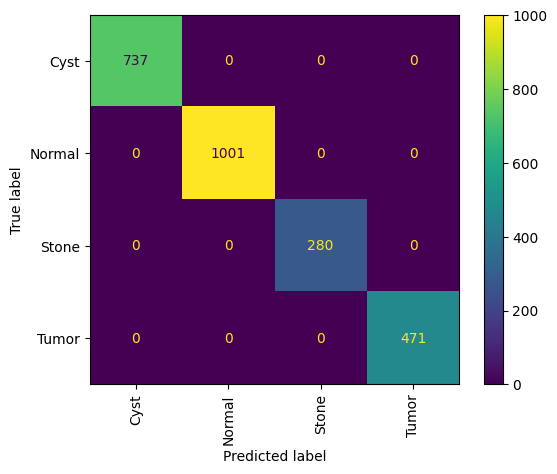

In [56]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

with open('MobileNet_confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']  

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

plt.show()


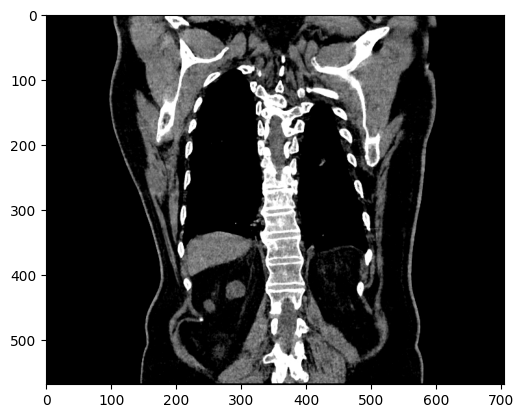

1/1 [==============================] - 1s 980ms/step


'Cyst'

In [57]:
img = cv2.imread('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = mobile_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

**ResNet50**

In [66]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential

weights = "imagenet"
resnet_model = ResNet50(input_shape=input_shape, weights=weights, include_top=False)
        
for layer in resnet_model.layers:
    layer.trainable = True

x = GlobalAveragePooling2D()(resnet_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
num_classes = 4
output = Dense(num_classes, activation='softmax')(x)

resnet_net = Model(inputs=resnet_model.input, outputs=output)

In [67]:
resnet_net.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [68]:
epochs=10
history = resnet_net.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/10
351/351 [==============================] - 106s 188ms/step - loss: 0.3386 - accuracy: 0.9183 - val_loss: 1.7604 - val_accuracy: 0.1876
Epoch 2/10
351/351 [==============================] - 64s 181ms/step - loss: 0.1212 - accuracy: 0.9812 - val_loss: 6.7976 - val_accuracy: 0.2925
Epoch 3/10
351/351 [==============================] - 64s 181ms/step - loss: 0.1296 - accuracy: 0.9778 - val_loss: 0.7288 - val_accuracy: 0.8341
Epoch 4/10
351/351 [==============================] - 64s 181ms/step - loss: 0.0523 - accuracy: 0.9954 - val_loss: 0.1662 - val_accuracy: 0.9542
Epoch 5/10
351/351 [==============================] - 64s 181ms/step - loss: 0.0510 - accuracy: 0.9927 - val_loss: 0.3551 - val_accuracy: 0.9221
Epoch 6/10
351/351 [==============================] - 64s 181ms/step - loss: 0.0265 - accuracy: 0.9984 - val_loss: 1.1595 - val_accuracy: 0.8562
Epoch 7/10
351/351 [==============================] - 64s 181ms/step - loss: 0.0685 - accuracy: 0.9871 - val_loss: 0.4502 - val_a

In [70]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('ResNet_training.csv', index=False)
resnet_net.save('ResNet_model.h5')

In [71]:
import pickle
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Assuming you have a model 'model' and a test dataset 'test_dataset'

# Make predictions using your model
predictions = resnet_net.predict(val)

# Get the true labels from the test dataset
true_labels = np.concatenate([y for x, y in val], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, np.argmax(predictions, axis=1))

# Save the confusion matrix in pkl format
with open('ResNet_confusion_matrix.pkl', 'wb') as f:
    pickle.dump(cm, f)


78/78 [==============================] - 5s 53ms/step


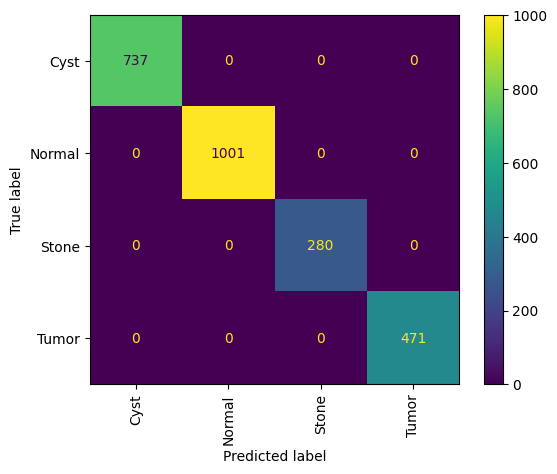

In [72]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Load the saved confusion matrix
with open('ResNet_confusion_matrix.pkl', 'rb') as f:
    cm = pickle.load(f)

# Define class names (assuming you have them)
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']   # Replace with your actual class names

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d')

# Show the confusion matrix plot
plt.show()


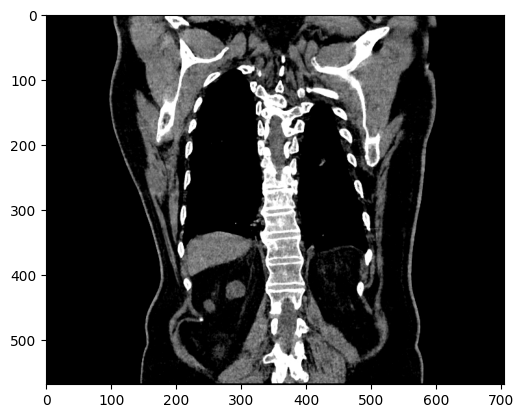

1/1 [==============================] - 1s 1s/step


'Cyst'

In [74]:
img = cv2.imread('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1).jpg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (224,224))
yhat = resnet_net.predict(np.expand_dims(resize/255, 0))
max_index = np.argmax(yhat)
label_to_class_name[max_index]

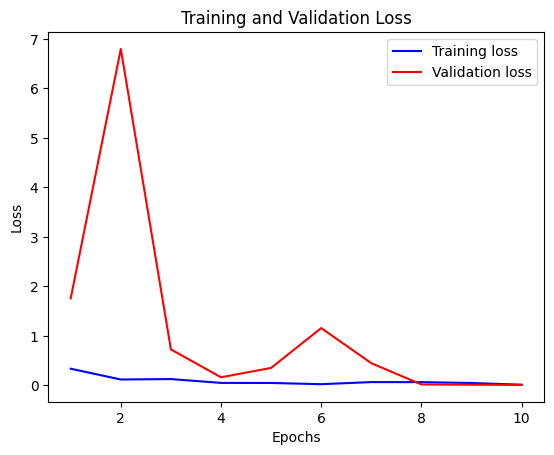

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

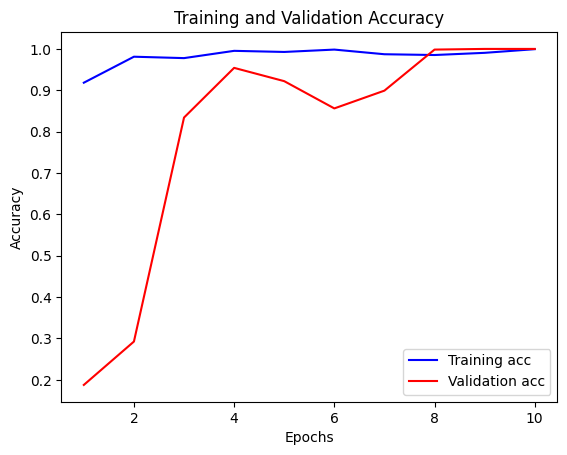

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()